In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from collections import defaultdict

In [2]:
t = pd.read_csv('../foodwebs/guittar2019/SILVA_taxonomy.csv') # taxonomy

In [3]:
m = pd.read_csv('../foodwebs/guittar2019/metadata.csv') # metadata

In [4]:
controls = list(m[m.treatment_group == 'Control']['subject'])

In [5]:
d = pd.read_csv('../foodwebs/guittar2019/otus.csv') # otu table

In [6]:
subjects = {}
count = 1
for key, row in d.iterrows():
    if row["subject"] not in subjects:
        subjects[row["subject"]] = count
        count +=1
d["subject_num"] = d["subject"].apply(lambda x: subjects[x]) # create subject_num for plotting purposes

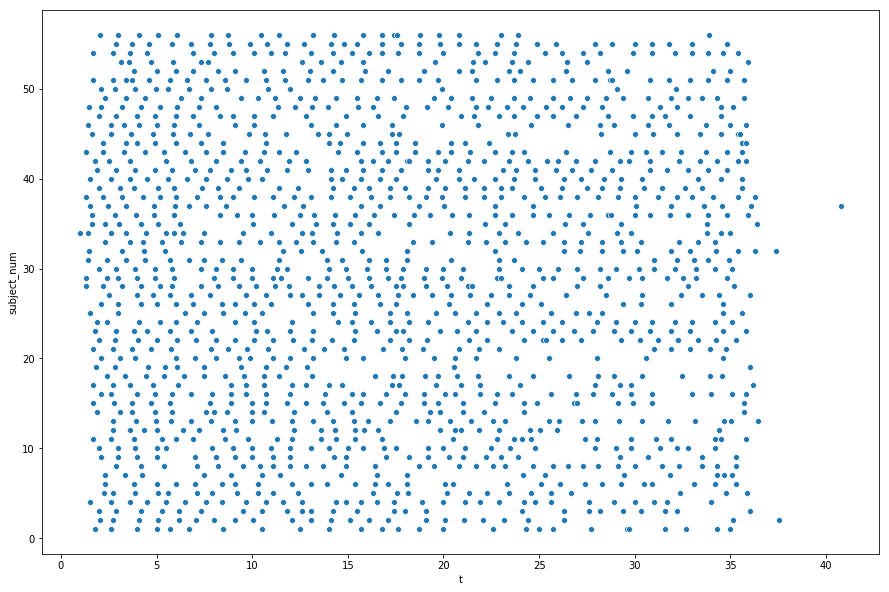

In [7]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="t", y="subject_num", data=d)
plt.show()

In [132]:
## Get just the OTU data rows (not the metadata rows)
otus = [item for item in d.columns if 'OTU' in item]
data= d[otus]

In [133]:
rel_abund = data.div(data.sum(axis=1), axis=0) ## This is a relative abundance table

In [10]:
from skbio.diversity import alpha

In [30]:
alpha_df = defaultdict(list)
for subject in d['subject'].unique():
    # create DF for just this subject
    d_subject = d[d.subject == subject] 
    data_subject = d_subject[otus]
    # filter to OTUs found at least 100 counts
    data_subject = data_subject[data_subject.columns[data_subject.max() > 100]]
    
    for otu in data_subject.columns:
        earliest_day = -1
        for day in data_subject[otu].index:
            if data_subject[otu][day] > 0:
                date = float(d_subject['t'][day])
                if earliest_day != -1 and earliest_day < date:
                    pass
                else:
                    earliest_day = date
        
        ## get delta alpha for this otu
        date_before = -1
        date_after = -1
        sorted_dates = list(d_subject['t'].sort_values())
        
        if sorted_dates.index(earliest_day) != 0 and sorted_dates.index(earliest_day) != len(sorted_dates) -1:
            date_before = sorted_dates[sorted_dates.index(earliest_day) - 1]
            date_of = sorted_dates[sorted_dates.index(earliest_day)]
            date_after = sorted_dates[sorted_dates.index(earliest_day) + 1]

            # calc delta alpha
            before_data = list(data_subject[d_subject.t == date_before].iloc[0])
            after_data = list(data_subject[d_subject.t == date_after].iloc[0])
            date_of_data = list(data_subject[d_subject.t == date_of].iloc[0])
            
            # calc delta beta
            delta_alpha = (alpha.observed_otus(after_data) - alpha.observed_otus(before_data)) / alpha.observed_otus(before_data)
            delta_alpha2 = (alpha.observed_otus(date_of_data) - alpha.observed_otus(before_data)) / alpha.observed_otus(before_data)
                        
            alpha_df['OTU'].append(otu)
            alpha_df['subject'].append(subject)
            alpha_df['day_of_arrival'].append(earliest_day)
            alpha_df['day_before'].append(date_before)
            alpha_df['day_after'].append(date_after)
            alpha_df['delta_alpha'].append(delta_alpha)
            alpha_df['delta_alpha2'].append(delta_alpha2)
            

In [31]:
alpha_df = pd.DataFrame(alpha_df)

In [32]:
alpha_df2 = alpha_df[alpha_df.subject.isin(controls)]

<Figure size 1080x720 with 0 Axes>

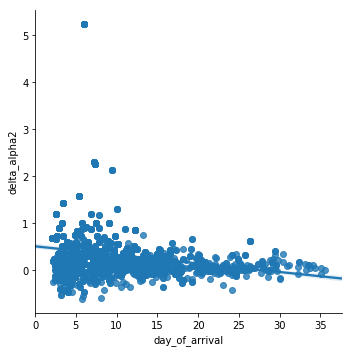

In [61]:
plt.figure(figsize=(15,10))
sns.lmplot(x="day_of_arrival", y="delta_alpha2", data=alpha_df)
plt.show()

0.31630604672672175

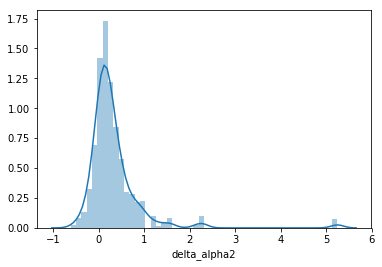

In [38]:
sns.distplot(alpha_df['delta_alpha2']);
np.mean(alpha_df['delta_alpha2'])

0.310843190169945

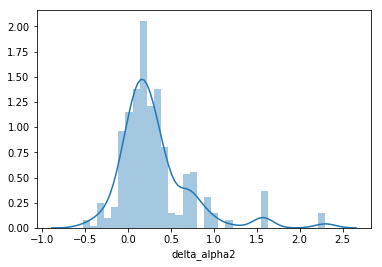

In [36]:
sns.distplot(alpha_df2['delta_alpha2']);
np.mean(alpha_df2['delta_alpha2'])

In [39]:
from scipy import stats

In [68]:
i = 0
means_alpha = list()
means_beta = list()
counts = list()
pvalues = list()
otus = list()
for otu in alpha_df['OTU'].unique():
    
    if alpha_df[alpha_df.OTU == otu].shape[0] >= 10:
        otu_data = alpha_df[alpha_df.OTU == otu]
        means_alpha.append(otu_data['delta_alpha2'].mean())
        counts.append(alpha_df[alpha_df.OTU == otu].shape[0])
        pvalues.append(stats.ttest_ind(list(otu_data['delta_alpha2']), list(alpha_df[alpha_df.OTU != otu]['delta_alpha2']))[1] / 2.0)
        otus.append(otu)
        i += 1
        
print(i)

60


In [98]:
import statsmodels.stats.multitest as multi
pvalues2 = multi.multipletests(pvalues, alpha=0.05, method='fdr_bh')

In [99]:
for otu in list(np.where(pvalues2[0])[0]):
    print(otus[otu])

OTU5


In [100]:
t.head()

,Unnamed: 0,otu,Kingdom,Phylum,Class,Order,Family,Genus,Species
0,1,OTU1,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,unclassified
1,2,OTU2,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Faecalibacterium,unclassified
2,3,OTU3,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,breve
3,4,OTU4,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis
4,5,OTU5,Bacteria,unclassified,unclassified,unclassified,unclassified,unclassified,unclassified


In [102]:
## By family

In [104]:
alpha_df.head()

,OTU,subject,day_of_arrival,day_before,day_after,delta_alpha,delta_alpha2
0,OTU10,E000823,12.5,10.5,14.0,0.523810,0.238095
1,OTU11,E000823,12.5,10.5,14.0,0.523810,0.238095
2,OTU116,E000823,34.3,32.7,35.0,-0.029412,0.029412
3,OTU13,E000823,5.0,4.0,5.7,0.142857,0.214286
4,OTU14,E000823,5.0,4.0,5.7,0.142857,0.214286


In [112]:
alpha_df['Family'] = np.nan
for f in t['Family'].unique():
    otus_in_family = t[t.Family == f]['otu']
    alpha_df.loc[alpha_df.OTU.isin(otus_in_family),'Family'] = f

In [117]:
good_families = []
for family in alpha_df.Family.unique():
    if len(alpha_df[alpha_df.Family == family]) > 10:
        good_families.append(family)

In [124]:
comparisons = []
pvalues2 = []
for family in good_families:
    for family2 in good_families:
        if family != family2 and set([family, family2]) not in comparisons:
            pvalues2.append(stats.ttest_ind(list(alpha_df[alpha_df.Family == family]['delta_alpha2']), list(alpha_df[alpha_df.Family == family2]['delta_alpha2']))[1] / 2.0)
            comparisons.append(set([family, family2]))

In [125]:
pvalues_families = multi.multipletests(pvalues2, alpha=0.05, method='fdr_bh')

for comparison in list(np.where(pvalues_families[0])[0]):
    print(comparisons[comparison])

In [129]:
## Pairwise

In [137]:
data.head()

,OTU1,OTU10,OTU100,OTU1000,OTU1002,OTU1003,OTU1004,OTU1005,OTU1006,OTU1007,...,OTU989,OTU99,OTU990,OTU991,OTU992,OTU993,OTU995,OTU997,OTU998,OTU999
0,265,0,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,74,0,37,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,214,295,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,753,359,0,0,0,0,0,0,0,0,...,0,8,0,0,0,0,0,0,0,0
4,736,188,0,0,0,0,0,0,0,0,...,0,9,0,0,0,0,0,0,0,0


In [131]:
len(otus)

60

In [134]:
## Get just the OTU data rows (not the metadata rows)
otus = [item for item in d.columns if 'OTU' in item]
data= d[otus]

In [135]:
rel_abund = data.div(data.sum(axis=1), axis=0) ## This is a relative abundance table

In [147]:
data_top_otus = data[data.columns[data.max() > 2200]] #this is the top 20 otus

In [148]:
data_top_otus.shape

(1481, 20)

In [149]:
from itertools import combinations

In [188]:
pairwise_df = defaultdict(list)

for otu_pair in combinations(data_top_otus.columns, 2):
    otu1 = otu_pair[0]
    otu2 = otu_pair[1]
    
    # get arrival date of each OTU and compare for each subject
    for subject in d['subject'].unique():
        # create DF for just this subject
        d_subject = d[d.subject == subject] 
        data_subject = d_subject[data_top_otus.columns]
        
        subject_abund = rel_abund[d.subject == subject]
        subject_abund = subject_abund[data_top_otus.columns]
        
        earliest_day1 = -1
        for day in data_subject[otu1].index:
            if data_subject[otu1][day] > 0:
                date = float(d_subject['t'][day])
                if earliest_day1 != -1 and earliest_day1 < date:
                    pass
                elif earliest_day1 != -1:
                    earliest_day1 = date
                    
                else:
                    earliest_day1 = date

        earliest_day2 = -1
        for day in data_subject[otu2].index:
            if data_subject[otu2][day] > 0:
                date = float(d_subject['t'][day])
                if earliest_day2 != -1 and earliest_day2 < date:
                    pass
                else:
                    earliest_day2 = date        
        
        ## If both OTUs were found in this subject, save the winner and the mean abund    
        if earliest_day1 != -1 and earliest_day2 != -1:
            
            sorted_dates = list(d_subject['t'].sort_values())
            date_of1 = sorted_dates[sorted_dates.index(earliest_day1)]
            otu1_mean = np.mean(subject_abund[d_subject.t > date_of1][otu1])

            date_of2 = sorted_dates[sorted_dates.index(earliest_day2)]
            otu2_mean = np.mean(subject_abund[d_subject.t > date_of2][otu2])

            if earliest_day1 > earliest_day2:
                arrival = 1
            elif earliest_day1 < earliest_day2:
                arrival = -1
            else:
                arrival = 0
            
            if arrival != 0:
                pairwise_df['OTU1'].append(otu1)
                pairwise_df['OTU2'].append(otu2)
                pairwise_df['subject'].append(subject)
                pairwise_df['arrival_order'].append(arrival)
                pairwise_df['OTU1_abund'].append(otu1_mean)
                pairwise_df['OTU2_abund'].append(otu2_mean)

In [216]:
del pairwise_df['OTU']

In [205]:
pairwise_df['subject'] = pairwise_df['subject'][:len(pairwise_df['OTU1'])]

In [217]:
pairwise_df = pd.DataFrame(pairwise_df)

In [255]:
pvalues1 = list()
pvalues2 = list()
otu_pairs = list()
for otu_pair in combinations(data_top_otus.columns, 2):
    otu1 = otu_pair[0]
    otu2 = otu_pair[1]
    
    #get data
    pair_data = pairwise_df[pairwise_df.OTU1 == otu1]
    pair_data = pair_data[pair_data.OTU2 == otu2]
    winner1 = np.nan_to_num(list(pair_data[pair_data.arrival_order == 1]['OTU1_abund']))
    loser1 = np.nan_to_num(list(pair_data[pair_data.arrival_order == -1]['OTU1_abund']))

    winner2 = np.nan_to_num(list(pair_data[pair_data.arrival_order == 1]['OTU2_abund']))
    loser2 = np.nan_to_num(list(pair_data[pair_data.arrival_order == -1]['OTU2_abund']))
    
    if len(winner1) >= 5 and len(loser1) >= 5:
        pvalues1.append(stats.ttest_ind(winner1, loser1)[1] / 2.0)
        pvalues2.append(stats.ttest_ind(winner2, loser2)[1] / 2.0)
        otu_pairs.append([otu1, otu2])

In [256]:
pvalues1_fdr = multi.multipletests(pvalues1, alpha=0.05, method='fdr_bh')
pvalues2_fdr = multi.multipletests(pvalues2, alpha=0.05, method='fdr_bh')

In [257]:
len(pvalues1_fdr[0])

91

In [268]:
for otu_pair in list(np.where(pvalues1_fdr[0])[0]):
    print(otu_pairs[otu_pair])
    print(str(t[t.otu == otu_pairs[otu_pair][0]]['Family']).split()[1] + "\t" +
          str(t[t.otu == otu_pairs[otu_pair][1]]['Family']).split()[1])


['OTU13', 'OTU14']
Pasteurellaceae	Veillonellaceae
['OTU13', 'OTU18']
Pasteurellaceae	Enterobacteriaceae
['OTU13', 'OTU2']
Pasteurellaceae	Ruminococcaceae
['OTU13', 'OTU4']
Pasteurellaceae	Bacteroidaceae
['OTU13', 'OTU43']
Pasteurellaceae	Bacteroidaceae
['OTU13', 'OTU5']
Pasteurellaceae	unclassified
['OTU13', 'OTU7']
Pasteurellaceae	Lachnospiraceae
['OTU13', 'OTU8']
Pasteurellaceae	Bacteroidaceae
['OTU18', 'OTU3']
Enterobacteriaceae	Bifidobacteriaceae
['OTU18', 'OTU4']
Enterobacteriaceae	Bacteroidaceae
['OTU18', 'OTU43']
Enterobacteriaceae	Bacteroidaceae
['OTU18', 'OTU60']
Enterobacteriaceae	Porphyromonadaceae
['OTU47', 'OTU8']
Clostridiaceae	Bacteroidaceae
['OTU5', 'OTU8']
unclassified	Bacteroidaceae
['OTU60', 'OTU8']
Porphyromonadaceae	Bacteroidaceae
['OTU7', 'OTU8']
Lachnospiraceae	Bacteroidaceae


In [261]:
otu_pair[0]

IndexError: invalid index to scalar variable.

In [247]:
np.where(pvalues2_fdr[0])[0]

array([], dtype=int64)

In [248]:
winner2

array([1.07947826e-01, 7.74666667e-02, 1.51875000e-02, 4.67333333e-02,
       2.60214286e-02, 4.75538462e-02, 1.04166667e-03, 1.97032258e-02,
       4.02692308e-02, 2.84761905e-03, 2.46387097e-02, 9.55379310e-02,
       7.09565217e-02, 3.70387097e-02, 2.76190476e-04, 4.47000000e-02,
       4.57230769e-02, 2.09473684e-03, 7.41212121e-03, 2.66380952e-02,
       8.26685714e-02, 9.62962963e-05, 5.80322581e-02, 3.46875000e-02,
       7.74193548e-05, 1.91304348e-04, 2.83333333e-04, 9.22903226e-02,
       1.04906667e-01])

In [249]:
loser2

array([1.14434783e-02, 1.35090909e-02, 5.11750000e-02, 2.31200000e-02,
       1.03600000e-02, 5.85619048e-02, 2.00000000e-04, 1.07857143e-02,
       4.70588235e-05, 1.42857143e-05, 3.38461538e-04])